In [305]:
import warnings
warnings.filterwarnings('ignore')

In [306]:
from timeit import default_timer as timer

In [307]:
from numpy import mean, std, arange
import pandas as pd
from collections import Counter

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RepeatedKFold, RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score

from sklearn.svm import LinearSVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.linear_model import LogisticRegression

plt.style.use('seaborn')
pd.set_option('precision', 3)

In [308]:
def split_labeled_dataset(filename, target_column=-1, encode_labels=False, drop_values=[], **args):
    """ Function to decompose a labeled dataset into two sets (X) -> predictors & y -> target"""   
    X, y, drop_colums = [], [], target_column
    encoder = None
    try:
        df = pd.read_csv(filename, **args)
        if len(drop_values) > 0:
            if target_column == -1:
                drop_column = len(df.columns) - 1                
            for drop_value in drop_values:
                df = df[df[drop_column] != drop_value]
        try:
            if type(target_column) == str:
                X, y = df.drop(target_column, axis=1).values, df[target_column]
            else:
                X, y = df.values[:, :target_column], df.values[:, target_column]          
            if encode_labels:
                try:
                    encoder = LabelEncoder()
                    y_enc = encoder.fit_transform(y)
                    y = y_enc
                except ImportError:
                    print("Sklearn package isn't installed in the system!!!")     
        except:
            print('Something went wrong splitting the dataset into predictors(X), and target(y)!!')      
    except ImportError as e:
        print("Pandas package isn't installed in the system!!!")
    return X, y, encoder  

In [309]:
def model_cross_evaluation(X, y, model, n_splits=5, n_repeats=3, reprod=True, stratify=True):
    
    random_state = 2652124       
    if reprod and stratify:
        cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state)
    elif not reprod and stratify:
        cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats)
    elif reprod and not stratify:
        cv = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state)
    else:
        cv = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats)
    
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    return scores

In [310]:
def potential_dropping_clases(filename, target_column=-1, n_split=5, **args):
    drop_class = []
    df = pd.read_csv(filename, **args)
    y = df.values[:, target_column]
    counting = Counter(y)
    for labeled_class, items in counting.items():
        percentage = items / len(y) * 100
        if items < n_split:
            drop_class.append([labeled_class, items, round(percentage, 3)])
    return drop_class


In [311]:
models = [
    LinearDiscriminantAnalysis(),          
    LinearSVC(),
    BaggingClassifier(n_estimators=1000),
    RandomForestClassifier(n_estimators=1000),
    ExtraTreesClassifier(n_estimators=1000),
    LogisticRegression(solver='lbfgs', multi_class='multinomial'),
    KNeighborsClassifier(n_neighbors=3),
    GaussianProcessClassifier()
]

names = [
    'Linear Discriminant Analysis', 
    'Support Vector Machine', 
    'Bagged Decision Trees', 
    'Random Forest', 
    'Extra Trees',
    'Multinomial Logistic Regression',
    'K-Nearest Neighbors',
    'Gaussian Process'
]

short_names = [    
    'LDA', 
    'SVM', 
    'BDT', 
    'RFC', 
    'ETX',
    'MLR',
    'KNN',
    'GPC'
]

In [312]:
potential_dropping_clases('../../../datasets/e-coli/ecoli.csv', header=None)

[['imS', 2, 0.595], ['imL', 2, 0.595]]

In [313]:
X, y, encoder = split_labeled_dataset('../../../datasets/e-coli/ecoli.csv', drop_values=['imS', 'imL'],                             
                             encode_labels=True, header=None)

In [314]:
results = []
elapsed_time = []
accuracy_mean = []
accuracy_std = []
for  model in models:
    start = timer()    
    scores = model_cross_evaluation(X, y, model)    
    elapsed_time.append(round(timer() - start, 2))   
    accuracy_mean.append(round(mean(scores), 2))                                                
    accuracy_std.append(round(std(scores), 2))
    results.append(scores)

In [315]:
summary = pd.DataFrame(dict(zip(['algorithm', 'abbreviation', 'time', 'mean', 'std'], 
         [names, short_names, elapsed_time, accuracy_mean, accuracy_std])))
summary.head(n=12)

,algorithm,abbreviation,time,mean,std
0,Linear Discriminant Analysis,LDA,1.83,0.88,0.03
1,Support Vector Machine,SVM,0.06,0.88,0.03
2,Bagged Decision Trees,BDT,17.88,0.85,0.04
3,Random Forest,RFC,17.23,0.89,0.03
4,Extra Trees,ETX,14.07,0.88,0.03
5,Multinomial Logistic Regression,MLR,0.24,0.81,0.02
6,K-Nearest Neighbors,KNN,0.17,0.86,0.03
7,Gaussian Process,GPC,2.86,0.76,0.03


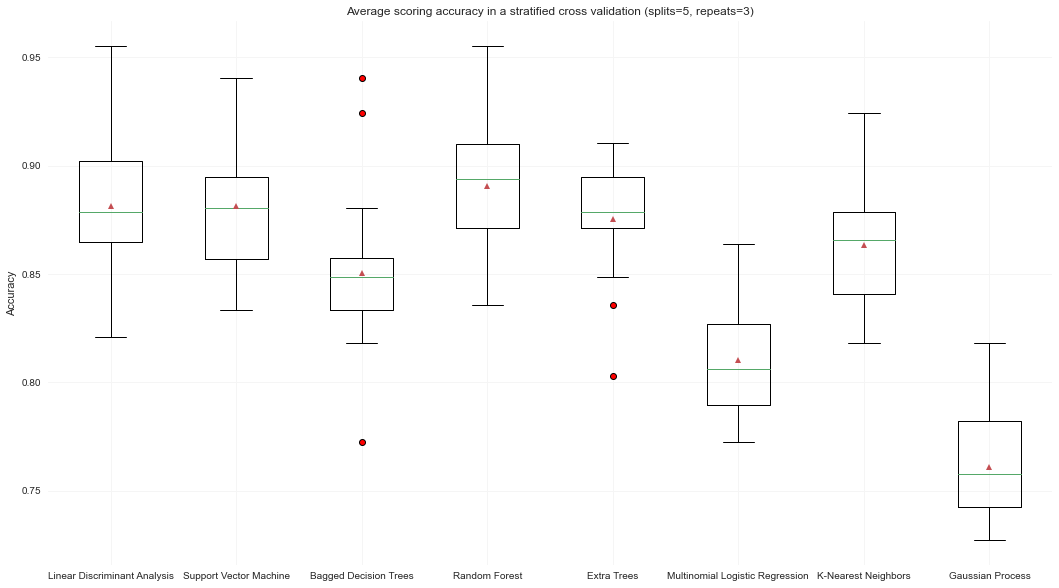

In [316]:
fig = plt.figure(figsize=(18, 10))
ax = plt.axes()
ax.set_facecolor("white")
_ = plt.grid(True, color='#f5f5f5', linestyle='-', linewidth=1)
outliers = dict(markerfacecolor='red', marker='o')
_ = plt.boxplot(results, labels=names, showmeans=True, flierprops=outliers)
_ = plt.ylabel('Accuracy')
_ = plt.title('Average scoring accuracy in a stratified cross validation (splits=5, repeats=3)')

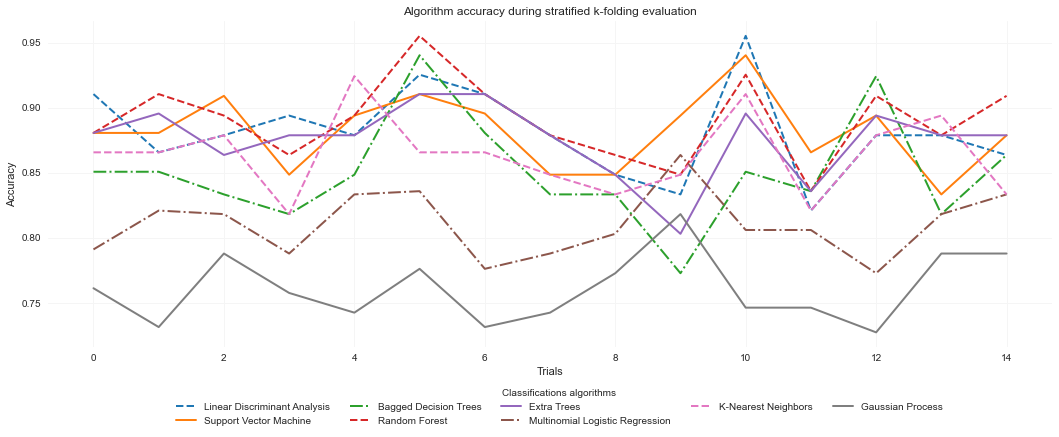

In [317]:
accuracy = DataFrame(dict(zip(names, results)), index=None)
fig = plt.figure(figsize=(18, 6))
ax = plt.axes()
ax.set_facecolor("white")
_ = plt.grid(True, color='#f5f5f5', linestyle='-', linewidth=1)
linestyles = ['--', '-', '-.']

for item in range(len(accuracy.columns)):
    _ = plt.plot(accuracy[accuracy.columns[item]], label=accuracy.columns[item], linewidth=2,
                 color=[*mcolors.TABLEAU_COLORS.values()][item], linestyle=linestyles[item % 3])

_ = plt.title('Algorithm accuracy during stratified k-folding evaluation')
_ = plt.ylabel('Accuracy')
_ = plt.xlabel('Trials')
_ = plt.legend(title='Classifications algorithms', ncol=5,
                     loc='center lower', bbox_to_anchor=(0.9, -0.1))

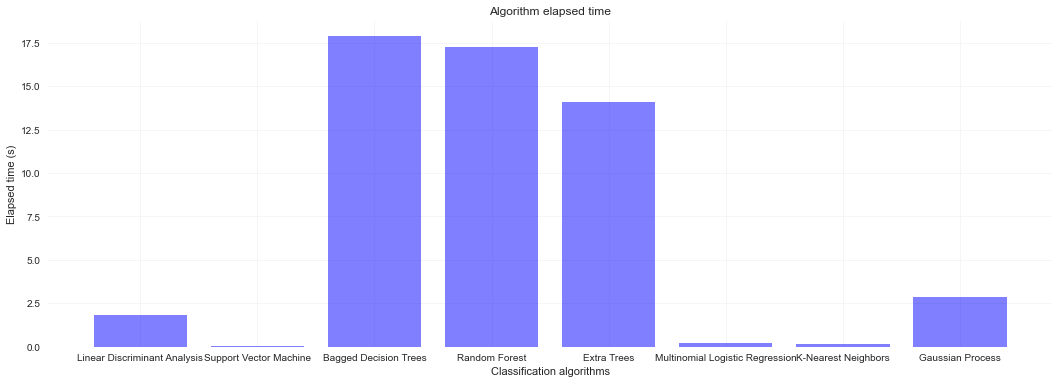

In [318]:
fig = plt.figure(figsize=(18, 6))
ax = plt.axes()
ax.set_facecolor("white")
_ = plt.grid(True, color='#f5f5f5', linestyle='-', linewidth=1)
_ = plt.bar(names, elapsed_time, color='blue', alpha=0.5)
_ = plt.title('Algorithm elapsed time')
_ = plt.ylabel('Elapsed time (s)')
_ = plt.xlabel('Classification algorithms')

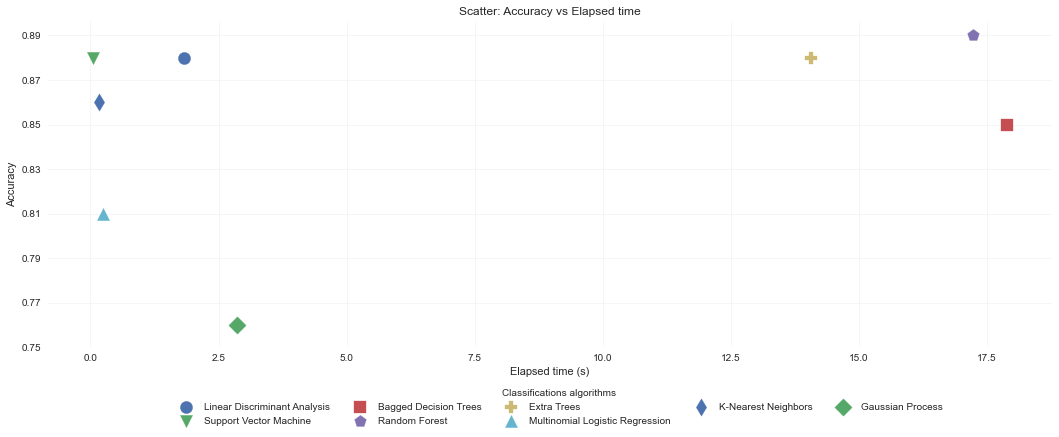

In [319]:
fig = plt.figure(figsize=(18, 6))
ax = plt.axes()
ax.set_facecolor("white")
_ = plt.grid(True, color='#f5f5f5', linestyle='-', linewidth=1)

markers = ['o', 'v', 's', 'p', 'P', '^', 'd', 'D']
for row in range(len(summary.index)):
    _ = plt.scatter(summary['time'][row], summary['mean'][row], label=summary['algorithm'][row],
                    marker=markers[row], s=150)

_ = plt.ylabel('Accuracy')
_ = plt.xlabel('Elapsed time (s)')
_ = plt.title('Scatter: Accuracy vs Elapsed time')
_ = plt.yticks([round(i, 2) for i in arange(0.75, 0.9, 0.02)])
_ = plt.legend(title='Classifications algorithms', ncol=5,
                     loc='center lower', bbox_to_anchor=(0.9, -0.1))

In [323]:
request =[
    [0.49,0.29,0.48,0.50,0.56,0.24,0.35],          
    [0.06,0.61,0.48,0.50,0.49,0.92,0.37],          
    [0.72,0.42,0.48,0.50,0.65,0.77,0.79],
    [0.78,0.68,0.48,0.50,0.83,0.40,0.29],
    [0.77,0.57,1.00,0.50,0.37,0.54,0.0], 
    [0.74,0.49,0.48,0.50,0.42,0.54,0.36]
         ]

In [327]:
model = LinearSVC()
model.fit(X, y)
y_hat = model.predict(request)
label = encoder.inverse_transform(y_hat)
label

array(['cp', 'im', 'imU', 'om', 'omL', 'pp'], dtype=object)

# Datasets URL

[UCI - Machine Learning Repository E. coli data](https://archive.ics.uci.edu/ml/datasets/ecoli)

# References & bibliography

#### Others articles

- [Wikipedia - Escherichia coli](https://en.wikipedia.org/wiki/Escherichia_coli)
- [https://machinelearningmastery.com/category/imbalanced-classification/](https://machinelearningmastery.com/category/imbalanced-classification/)

#### Python packages involved

- [Matplotlib Visualization with Python](https://matplotlib.org/)
- [Pandas: powerful Python data analysis toolkit](https://pandas.pydata.org/docs/pandas.pdf)
- [scikit-learn Machine Learning in Python - Classification](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning)
- [NumPy v1.19.dev0 Manual](https://numpy.org/devdocs/reference/index.html)

#### Books

- [Imbalanced Learning: Foundations, Algorithms, and Applications]()
- [Learning from Imbalanced Data Sets]()
- [Dealing with Imbalanced and Weakly Labelled Data in Machine Learning using Fuzzy and Rough Set Methods]()